# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [7]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()



hr_dataset = pd.read_sql_query("select * from hr_dataset", conn)
print(hr_dataset.groupby('Performance Score').count())
production_staff = pd.read_sql_query("select * from production_staff", conn)
print(production_staff)
salary_grid = pd.read_sql_query("select * from salary_grid", conn)
print(salary_grid)
recruiting_costs = pd.read_sql_query("select * from recruiting_costs", conn)
print(recruiting_costs)





                           id  Employee Name  Employee Number  marriedid  \
Performance Score                                                          
90-day meets               31             31               31         31   
Exceeds                    28             28               28         28   
Exceptional                 9              9                9          9   
Fully Meets               181            181              181        181   
N/A- too early to review   37             37               37         37   
Needs Improvement          15             15               15         15   
PIP                         9              9                9          9   

                          maritalstatusid  genderid  empstatus_id  deptid  \
Performance Score                                                           
90-day meets                           31        31            31      31   
Exceeds                                28        28            28      28   
Excepti

    manager_score             manager
0               0      Michael Albert
1              -1          Simon Roup
2               8          John Smith
3               7            Amy Dunn
4               5      Webster Butler
5               9      Brannon Miller
6               1  Brandon R. LeBlanc
7              15          Janet King
8               7       Lynn Daneault
9               8        Elijiah Gray
10              3     Alex Sweetwater
11             11       David Stanley
12             -2        Peter Monroe
13              5     Jennifer Zamora
14             10      Kissy Sullivan
15             14       Kelley Spirea
16             11       Ketsia Liebig
17              1      Debra Houlihan


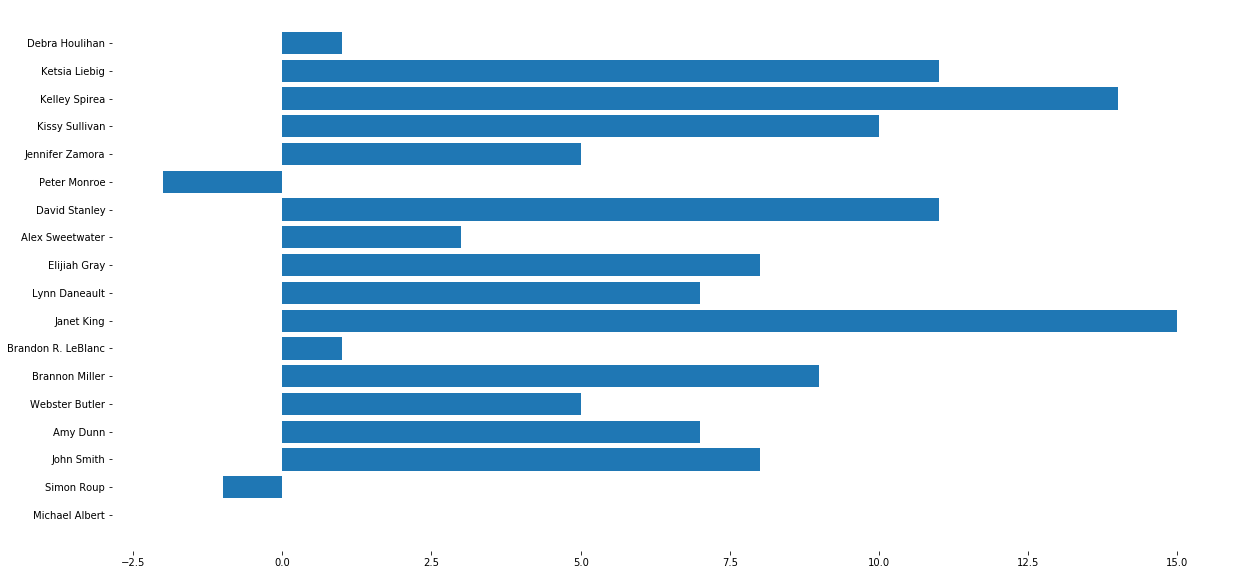

In [14]:
#Гипотеза - разные менеджеры имеют разную эффективность при работе с подчиненными.

manager = pd.read_sql_query("""SELECT a.summa - b.summa as Manager_score, a.manager
                               FROM(
                                   SELECT "Manager Name" as manager, COUNT (*) as summa FROM hr_dataset
                                   WHERE "Performance Score" IN ('Fully Meets', 'Exceeds', 'Exceptional')
                                   GROUP BY "Manager Name") a
                               JOIN(
                                   SELECT "Manager Name" as manager, COUNT (*) as summa FROM hr_dataset 
                                   WHERE "Performance Score" NOT IN ('Fully Meets', 'Exceeds', 'Exceptional')
                                   GROUP BY "Manager Name") b
                               ON a.manager = b.manager
                               """, conn)

print(manager)



from pandas.plotting import register_matplotlib_converters
%matplotlib inline

x = []
y = []


x = manager['manager']
y = manager['manager_score']
plt.figure(figsize=(20,10))
plt.barh(x, y)   
plt.subplots_adjust(hspace=0.8)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

#Итак, я брал для каждого менеджера я оценивал Performance Score, то есть смотрел какое отношение тех кто соответствует
# к тем кто не соответвтует, и собствено показал это на графике. Нужно анализировать дальше, почему у каких то менеджеров сотрудники чаще
# соответвуют нормам и продолжают работать, а у кого-то отрицательная динамика.

     salary work_days_category
0     23.00  More Then 5 years
1     54.50  More Then 5 years
2     50.50     Less then year
3     55.00          1-3 years
4     51.00          3-5 years
..      ...                ...
203   22.00          3-5 years
204   29.00          3-5 years
205   22.00          3-5 years
206   24.25          3-5 years
207   27.00  More Then 5 years

[208 rows x 2 columns]


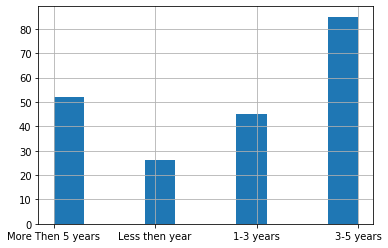

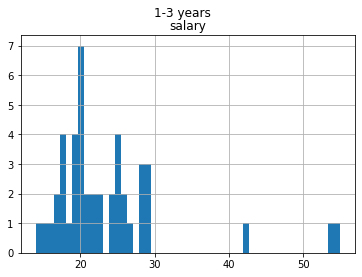

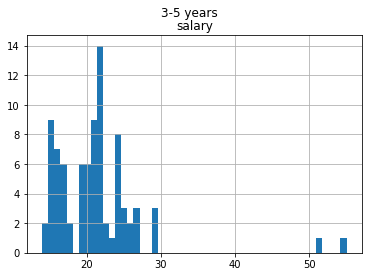

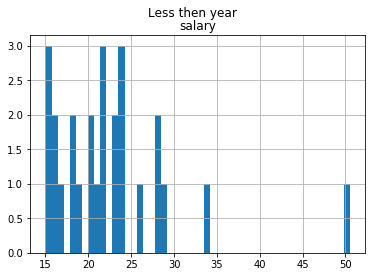

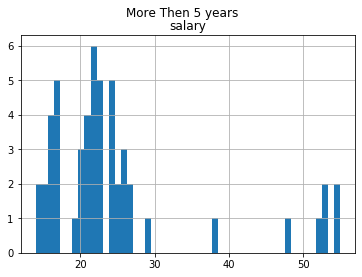

In [3]:
#зависимость семейного положения от заработной платы
salary = pd.read_sql_query("""SELECT salary::numeric,
                              CASE 
                                  WHEN work_days <=356 THEN 'Less then year'
                                  WHEN 357 <= work_days and work_days <= 1068 THEN '1-3 years'
                                  WHEN 1069 <= work_days and work_days <= 1780 THEN '3-5 years'
                                  WHEN work_days >= 1781 THEN 'More Then 5 years'
                              END work_days_category

                              FROM (SELECT "Days Employed" as work_days, "Employee Name" as name FROM hr_dataset) one
                              JOIN (SELECT "Employee Name" as name, "Pay" as salary FROM production_staff) two
                              ON one.name = two.name""", conn)

print(salary)


salary['work_days_category'].hist()
for name, data in salary.groupby('work_days_category'):
    data.hist(bins = 50)
    pl.suptitle(name)
    

#как мы видим по гистограмме рассеивания - гипотеза не подтвердилась. Есть разница в количестве, но колебания по величине зарплаты незначительные

                      Employee Source                  position  count
0                  Website Banner Ads        Area Sales Manager      7
1                              Indeed              BI Developer      4
2                   Employee Referral    Database Administrator      6
3                   Employee Referral          Network Engineer      3
4                   Employee Referral        Production Manager      3
5   Search Engine - Google Bing Yahoo   Production Technician I     16
6                  Newspager/Magazine  Production Technician II      8
7                              Indeed       Senior BI Developer      3
8                  Diversity Job Fair         Software Engineer      2
9                     Vendor Referral                   Sr. DBA      3
10                  Employee Referral      Sr. Network Engineer      3


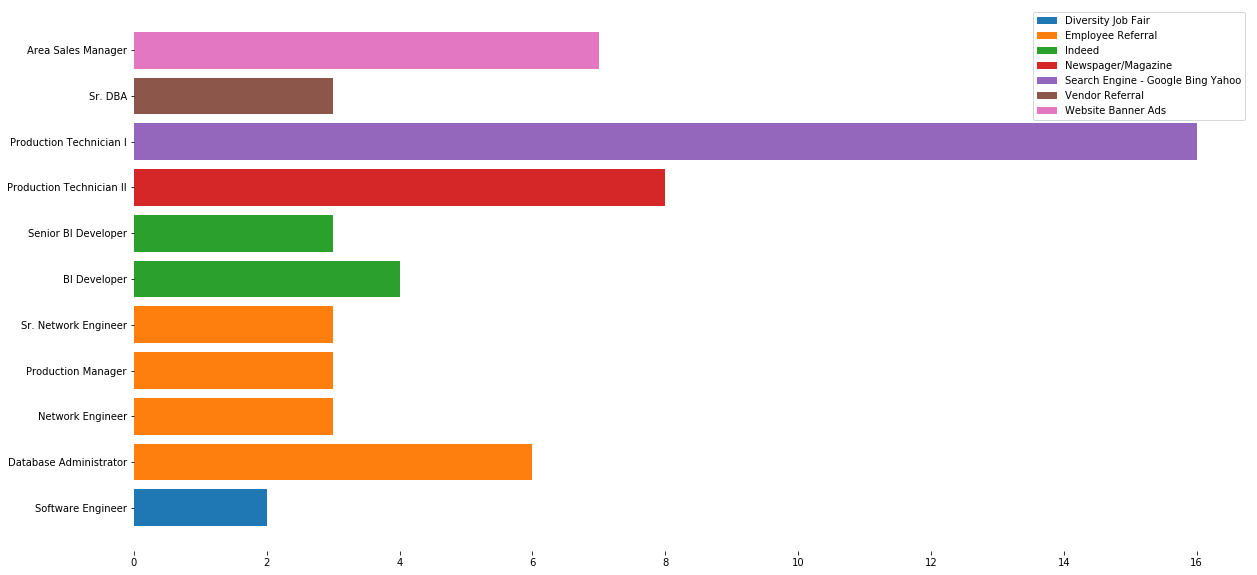

In [4]:
#Зависимость должности от источника, на котором сотрудник был найден

source = pd.read_sql_query("""SELECT DISTINCT ON("position") "Employee Source", "position", "count"
                              FROM(
                                  SELECT "Employee Source", "position", COUNT("Employee Source") as count
                                  FROM hr_dataset
                                  GROUP BY "position", "Employee Source"
                              ) a
                              WHERE "count" > 1
                              GROUP BY "Employee Source", "position", "count"
                              ORDER BY "position", "count" DESC

                              """, conn)

print(source)

x = []
y = []
plt.figure(figsize=(20,10))
for name,data in source.groupby('Employee Source'):
    y = data['count']
    x = data['position']
    plt.barh(x, y, label = name)  
plt.legend()
plt.xticks()
plt.yticks()
plt.subplots_adjust(hspace=0.8)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

#собственно, по граику и цифрам видим, на каких источниках какие должности искать эффективнее всего

                     position  salary  gender
0                Accountant I   51425  Female
1                Accountant I   51425    Male
2                Accountant I   51425    Male
3    Administrative Assistant   40000  Female
4    Administrative Assistant   40000  Female
..                        ...     ...     ...
227  Production Technician II   48000  Female
228  Production Technician II   48000    Male
229  Production Technician II   48000    Male
230  Production Technician II   48000  Female
231  Production Technician II   48000    Male

[232 rows x 3 columns]


Text(0, 0.5, 'Количество ссотрудников')

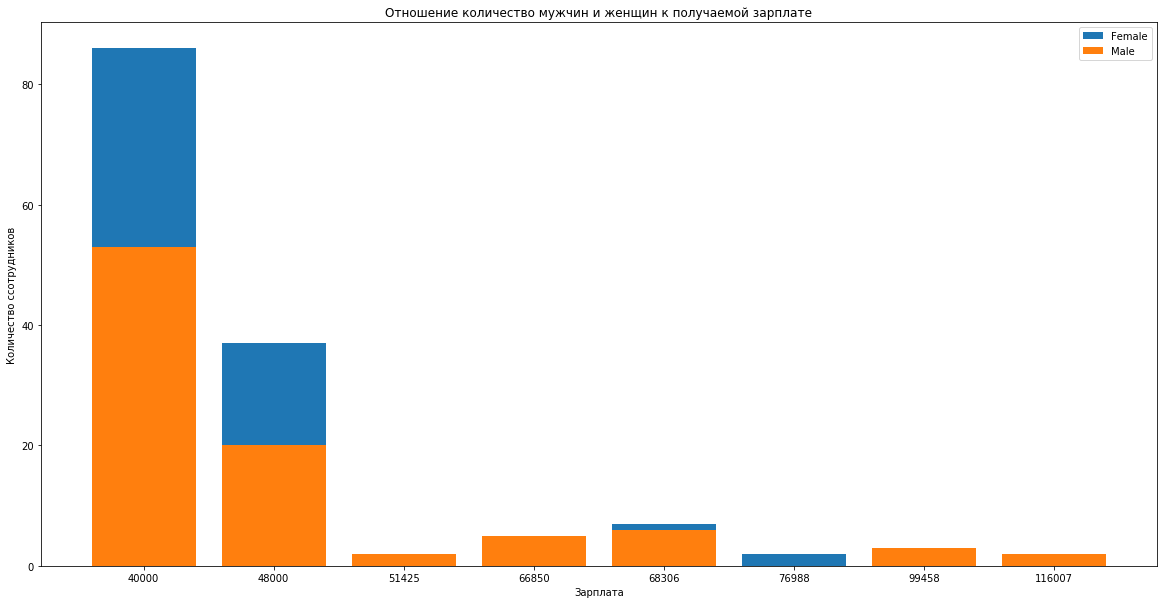

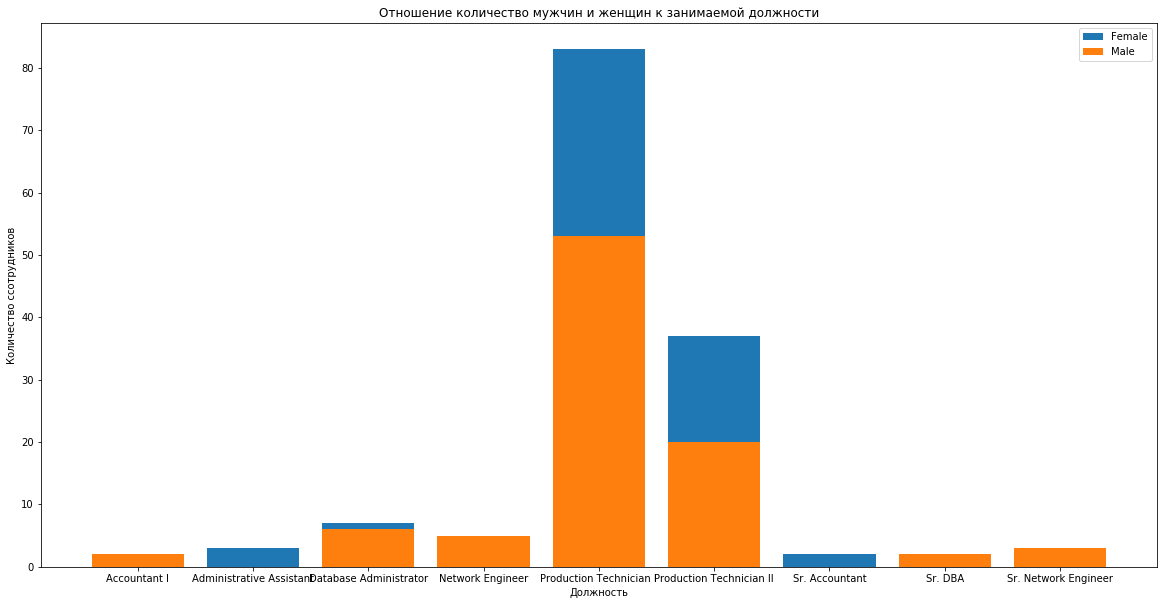

In [19]:
# есть зависимость между полом и получаемой зарплатой

gender = pd.read_sql_query("""SELECT "position", "Salary Mid" as salary,
                              CASE 
                                  WHEN genderid = 0 THEN 'Female'
                                  WHEN genderid = 1 THEN 'Male'
                              END gender
                              FROM hr_dataset
                              JOIN salary_grid
                              ON hr_dataset."position" = salary_grid."Position"

                              """, conn)

print(gender)
fig, subplot1 = plt.subplots(figsize=(20,10))
for name, data in gender.groupby('gender'):
    x = []
    y = []
    for name2, data2 in data.groupby('salary'):
        x += [str(name2)]
        y += [len(data2.index)]   
    plt.bar(x, y, label = name)

plt.legend()
subplot1.set_title('Отношение количество мужчин и женщин к получаемой зарплате')
subplot1.set_xlabel('Зарплата')
subplot1.set_ylabel('Количество ссотрудников')


fig, subplot2 = plt.subplots(figsize=(20,10))
for name, data in gender.groupby('gender'):
    x = []
    y = []
    for name2, data2 in data.groupby('position'):
        x += [str(name2)]
        y += [len(data2.index)]   
    plt.bar(x, y, label = name)
    
    
plt.legend()
subplot2.set_title('Отношение количество мужчин и женщин к занимаемой должности')
subplot2.set_xlabel('Должность')
subplot2.set_ylabel('Количество ссотрудников')

#из графиков видно, что во первых женщин бльше чем мужчин, во вторых сильной релевантности пола от получаемой зарплаты нет.
# Незначительно больше мужчин получают зарплату выше чем остальные, но в остальном мячик на женской стороне.


## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


Статистика просмотров от возрастания к уменьшению:
    comments  likes  reposts  views  hour  day
26        28    150       10  33837     9   25
18        27    210       34  31888    13    2
30        22    166       18  29492     7   22
29        17    229       23  26979    10   22
19        11    115        3  26506    10    1
17        19    142        7  26095     8    4
24         8     90        5  25067     9   27
33         7    171       15  24935     7   21
21         5    116       14  24489     9   29
10        22    199       23  23836    11   10
15        19    138       12  23633     9    5
25         0     98       17  23553    11   26
7         11    117        8  23367     9   12
27         5    105        6  23165    11   24
4          9    111        3  22868     8   14
28        25     76       16  22809    10   23
22         0     81        0  21880    14   28
6         16    138        8  21450     9   13
23         5     46        3  20535    11   27
16       

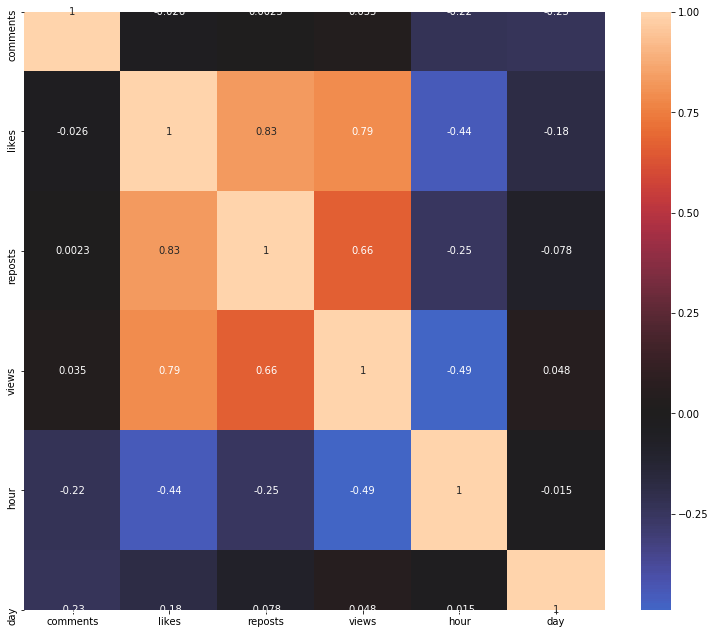

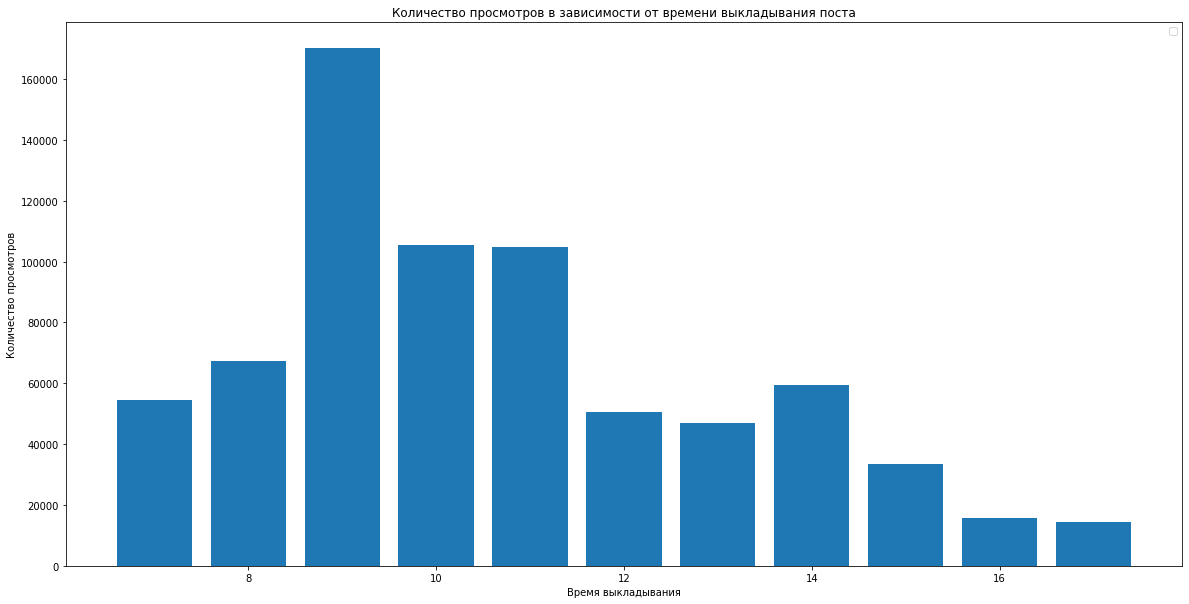

In [24]:
import re
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import pymorphy2
import json

def anomaly(df,column): #функция для рассчета аномалий
    upper_level = df[column].mean() + 3*df[column].std()
    lower_level = df[column].mean() - 3*df[column].std()
    anomaly_upper = df[df[column] >= upper_level]
    anomaly_lower = df[df[column] <= lower_level]
    return anomaly_upper.append(anomaly_lower)

def statistic_by_words(df,column):   #функция для анализа вовлеченности пользователей по тегам
    print('***********************************')
    print('Метрика:',column.title())
    word1 = df.groupby('key1')[column].agg(['sum','count']).reset_index()
    word2 = df.groupby('key2')[column].agg(['sum','count']).reset_index()
    word2 = word2[word2['key2'] != 0]
    word2 = word2.rename(columns={'key2': 'key1'})
    word1 = word1.append(word2)
    total = word1.groupby('key1').sum()
    print(total.sort_values(by = 'sum', ascending = False))
    print('***********************************')
    
    

with open('vk1.json') as json_file:
    data = json.load(json_file)

#сощдаем датафрейм, приводим в порядок дату
vk = []
for i in range(len(data)):
    vk += data[i]
vk = pd.DataFrame(vk)
vk['date'] = pd.to_datetime(vk['date'], unit='s')

#выбираем только нужные столбцы, получаем из словарей только нужные значения общей суммы
vk = vk[['comments','date','likes','reposts','text','views']]
for column in vk:
    try:
        vk[column] = vk[column].apply(lambda x: x.get('count'))
    except:
        pass
#получаем теги
key = []
for text in vk['text']:
    a = re.findall(r'#(\w+)',text)
    if len(a) == 2:
        key += [a]
    else:
        a += [0]
        key += [a]
vk['key'] = key
vk['key1'] = vk['key'].apply(lambda x: x[0])
vk['key2'] = vk['key'].apply(lambda x: x[1])

#отбираем для аттистики только исчесляемые параметры
vk_statistic = vk[['comments','likes','reposts','views','date']]
vk_statistic['hour'] = vk_statistic['date'].apply(lambda x: x.hour)
vk_statistic['day'] = vk_statistic['date'].apply(lambda x: x.day)
vk_statistic = vk_statistic.drop(['date'], axis = 1)

#находим аномалии
anomal = pd.DataFrame()
for column in vk_statistic:
    anomaly_total = anomaly(vk_statistic,column)
    anomal = anomal.append(anomaly_total)

anomal = anomal.drop_duplicates()


#убираем строки с аномалией из статистики, строим корреляционную матрицу

vk_statistic = vk_statistic.drop(anomal.index, axis = 0)
corr_vk = vk_statistic.corr()
plt.figure(figsize=(13,11))
sns.heatmap(corr_vk, center=0, annot=True)

#структурируем просмотры отталкиваясь от часов и дней
print('Статистика просмотров от возрастания к уменьшению:')
print(vk_statistic.sort_values(by = 'views', ascending = False))
print('Статистика просмотров в завсимости от часа выкладывания поста:')
print(vk_statistic.groupby('hour')['views'].agg(['count','sum']))

hour_statistic = vk_statistic.groupby('hour')['views'].agg(['count','sum']).reset_index()
print(hour_statistic)
fig, subplot3 = plt.subplots(figsize=(20,10))
x = hour_statistic['hour']
y = hour_statistic['sum'] 
plt.bar(x, y)

plt.legend()
subplot3.set_title('Количество просмотров в зависимости от времени выкладывания поста')
subplot3.set_xlabel('Время выкладывания')
subplot3.set_ylabel('Количество просмотров')


#избавляемся от общих ключей и от аномальных строк

vk = vk.drop('key', axis = 1)
vk = vk.drop(anomal.index, axis = 0)

#анализируем лайки

print('Статистика зависимости просмотров, комментариев и репостов в зависимости от рубрики:')
for column in vk[['comments','likes','reposts']]:
    statistic_by_words(vk,column)
    
    
# Итак, мы видим что корреляции от времени выкладывания поста нет, ни по дням ни по часам. Но видим, что чаще всего посты выкладываются
# с 9 утра до 11. По всей видимости маркетологические исследования уже были, и данное время посчиталось оптимальным, поэтому в сумме просмотры
# постов выложенных в это время набирают больше всего просмотров.
# Что касается рубрик, то мы видим, что охотнее всего людям нравятся рубрики В_закладки, и Дизайн, так же немало репостов у рубрики
# программирование, в них можно и копать, есть рубрики над которыми стоит поработать и как-то их изменить.


